In [17]:
import sys
sys.path.append('..')
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import pyro
from utils import *
torch.manual_seed(0)

Define prior on $\theta$

In [18]:
mu_theta =torch.tensor(6.)
sigma2_theta =torch.tensor(3.)
prior = torch.distributions.Normal(mu_theta, torch.sqrt(sigma2_theta))

Generate $D_\theta$ according to some prior distribution

In [19]:
n_D = 10
D_theta =torch.linspace(-1,1, n_D)

Generate $D_x$ according to some unknown linear $f(D_\theta)$

In [20]:
mu_phi = torch.tensor(0.)
sigma2_phi = torch.tensor(1.)
phi0 = torch.distributions.Normal(mu_phi, sigma2_phi).sample()
phi0=torch.tensor([1.])
sigma2_simulateur = torch.tensor(0.25)
f = lambda y: phi0*y
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*torch.sqrt(sigma2_simulateur)

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [42]:
theta0 = prior.sample()
theta0 = torch.tensor([6.])
print('theta_0 = ' + str(theta0.item()))
n_x0= 1
x0 = simulateur(theta0.repeat(n_x0))

theta_0 = 6.0


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

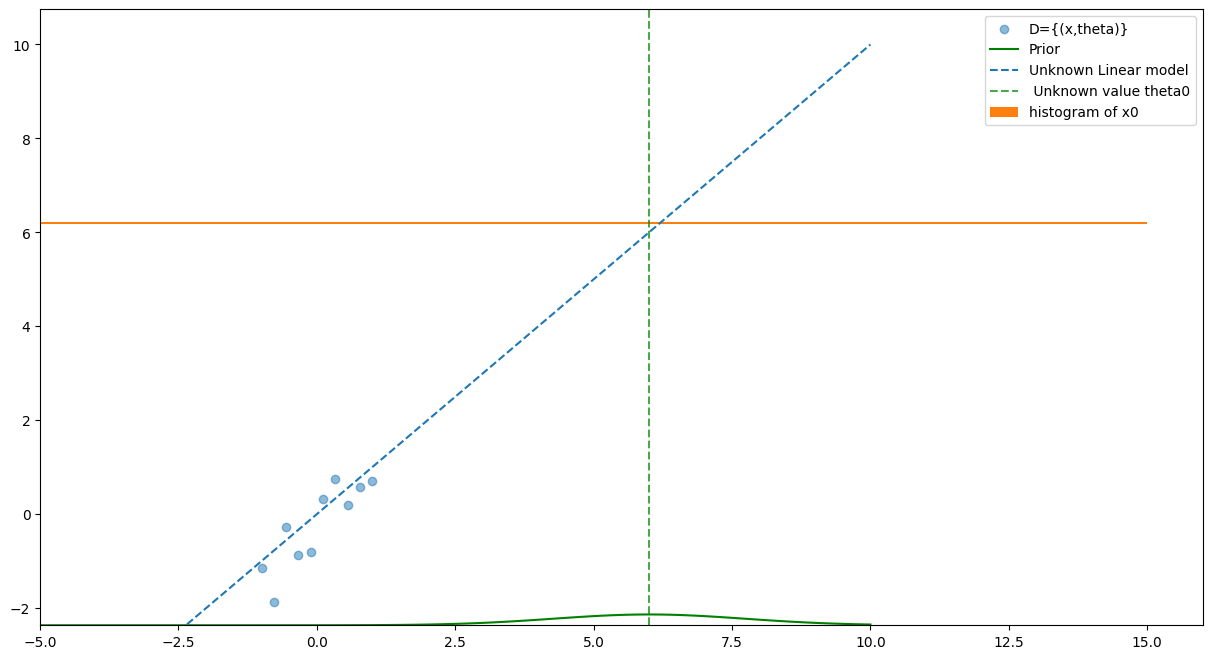

In [43]:
plt.figure(figsize = (15,8))
y_min = torch.min(torch.cat([D_x,x0])) - 0.5
plt.scatter(D_theta.numpy(), D_x.numpy(), alpha =.5, label = 'D={(x,theta)}') 
tt = torch.linspace(-5,10,100)
plt.plot(tt, y_min + torch.exp(prior.log_prob(tt.unsqueeze(-1))), color = 'green', label='Prior')
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = 'Unknown Linear model')
plt.axvline(theta0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [44]:
class generative_bayesian_linear_regression:
    def __init__(self,sigma2_simulateur, mu_theta = torch.tensor(0.), sigma2_theta = torch.tensor(1.), mu_phi = torch.tensor(0.) , sigma2_phi = torch.tensor(1.)): 
        self.sigma2_simulateur = sigma2_simulateur
        self.mu_theta = mu_theta
        self.sigma2_theta = sigma2_theta 
        self.mu_phi = mu_phi
        self.sigma2_phi = sigma2_phi
        
    def compute_phi_given_D_moments(self, D_theta, D_x):
        assert D_theta.shape == D_x.shape,'Mismatch in number samples'
        sigma2_phi_given_D = (D_theta@D_theta/self.sigma2_simulateur + self.sigma2_phi**(-1))**(-1)
        mu_phi_given_D = sigma2_phi_given_D*(D_x@D_theta/self.sigma2_simulateur + self.sigma2_phi**(-1)*self.mu_phi)
        return mu_phi_given_D,sigma2_phi_given_D
    
    def compute_theta_given_x0_phi_moments(self,x0,phi):
        sigma2_theta_given_x0_phi = 1/(1/self.sigma2_theta + x0.shape[0]*torch.square(phi)/self.sigma2_simulateur)        
        mu_theta_given_x0_phi = sigma2_theta_given_x0_phi*(self.mu_theta/self.sigma2_theta + phi*torch.sum(x0)/self.sigma2_simulateur)
        return mu_theta_given_x0_phi, sigma2_theta_given_x0_phi 

    def log_joint_distribution(self, theta, phi,x0, D_theta, D_x):
        mean_phi_D, var_phi_D = self.compute_phi_given_D_moments(D_theta, D_x)
        parameter_posterior = torch.distributions.Normal(mean_phi_D, torch.sqrt(var_phi_D))
        
        log_prior = torch.distributions.Normal(self.mu_theta, torch.sqrt(self.sigma2_theta)).log_prob(theta)
        
        mean = phi*theta
        var = self.sigma2_simulateur.repeat(mean.shape[0])
        log_likelihood = torch.sum(torch.distributions.Normal(mean.unsqueeze(1).repeat(1,x0.shape[0]), torch.sqrt(var).unsqueeze(1).repeat(1,x0.shape[0])).log_prob(x0.unsqueeze(0).repeat(mean.shape[0],1)), dim = -1)
        
        return parameter_posterior.log_prob(phi)+log_prior+log_likelihood
    
    def marginal_log_posterior(self, theta,x0, D_theta, D_x):
        prior = torch.distributions.Normal(self.mu_theta, self.sigma2_theta).log_prob(theta)
        mu_phi_given_D, sigma2_phi_given_D = self.compute_phi_given_D_moments(D_theta, D_x)
        gamma = theta.unsqueeze(-1).repeat(1, x0.shape[0])
        likelihood = torch.distributions.MultivariateNormal(mu_phi_given_D*gamma, gamma.unsqueeze(-1)@gamma.unsqueeze(-2)*sigma2_phi_given_D + torch.eye(x0.shape[0])*self.sigma2_simulateur).log_prob(x0.unsqueeze(0).repeat(theta.shape[0],1))
        mu_x_given_theta_D = theta*mu_phi_given_D
        return prior + likelihood
    
class discriminative_bayesian_linear_regression:
    def __init__(self,sigma2_simulateur, mu_theta = torch.tensor(0.), sigma2_theta = torch.tensor(1.), mu_phi = torch.tensor(0.) , sigma2_phi = torch.tensor(1.)): 
        self.sigma2_simulateur = sigma2_simulateur
        self.mu_theta = mu_theta
        self.sigma2_theta = sigma2_theta 
        self.mu_phi = mu_phi
        self.sigma2_phi = sigma2_phi
        
    def compute_phi_given_D_moments(self, D_x, D_theta):
        assert D_theta.shape == D_x.shape,'Mismatch in number samples'
        sigma2_phi_given_D = (D_theta@D_theta/self.sigma2_simulateur + self.sigma2_phi**(-1))**(-1)
        mu_phi_given_D = sigma2_phi_given_D*(D_x@D_theta/self.sigma2_simulateur + self.sigma2_phi**(-1)*self.mu_phi)
        return mu_phi_given_D,sigma2_phi_given_D
    
    def compute_theta_given_x0_phi_moments(self,x0,phi):
        assert x0.shape[0] == 1, 'discriminative does not handle several observations'
        sigma2_theta_given_x0_phi = 1/(1/self.sigma2_theta + x0.shape[0]*torch.square(phi)/self.sigma2_simulateur)        
        mu_theta_given_x0_phi = sigma2_theta_given_x0_phi*(self.mu_theta/self.sigma2_theta + phi*torch.sum(x0)/self.sigma2_simulateur)
        return mu_theta_given_x0_phi, sigma2_theta_given_x0_phi 

    def log_joint_distribution(self, theta, phi,x0, D_theta,D_x):
        mean_phi_D, var_phi_D = self.compute_phi_given_D_moments(D_theta, D_x)
        parameter_posterior = torch.distributions.Normal(mean_phi_D, torch.sqrt(var_phi_D))
        
        log_prior = torch.distributions.Normal(self.mu_theta, torch.sqrt(self.sigma2_theta)).log_prob(theta)
        
        mean = phi*theta
        var = self.sigma2_simulateur.repeat(mean.shape[0])
        log_likelihood = torch.sum(torch.distributions.Normal(mean.unsqueeze(1).repeat(1,x0.shape[0]), torch.sqrt(var).unsqueeze(1).repeat(1,x0.shape[0])).log_prob(x0.unsqueeze(0).repeat(mean.shape[0],1)), dim = -1)
        
        return parameter_posterior.log_prob(phi)+log_prior+log_likelihood
    
    def marginal_log_posterior(self, theta,x0, D_theta, D_x):
        prior = torch.distributions.Normal(self.mu_theta, self.sigma2_theta).log_prob(theta)
        mu_phi_given_D, sigma2_phi_given_D = self.compute_phi_given_D_moments(D_theta, D_x)
        gamma = theta.unsqueeze(-1).repeat(1, x0.shape[0])
        likelihood = torch.distributions.MultivariateNormal(mu_phi_given_D*gamma, gamma.unsqueeze(-1)@gamma.unsqueeze(-2)*sigma2_phi_given_D + torch.eye(x0.shape[0])*self.sigma2_simulateur).log_prob(x0.unsqueeze(0).repeat(theta.shape[0],1))
        mu_x_given_theta_D = theta*mu_phi_given_D
        return prior + likelihood
    
blr = generative_bayesian_linear_regression(sigma2_simulateur, mu_theta=mu_theta, sigma2_theta = sigma2_theta,mu_phi = mu_phi, sigma2_phi = sigma2_phi)

Sample joint with Gibbs sampling

In [45]:
mean_phi_D, var_phi_D = blr.compute_phi_given_D_moments(D_theta, D_x)
current_phi = torch.distributions.Normal(mean_phi_D, torch.sqrt(var_phi_D)).sample()

mean_theta_x0_phi, var_theta_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
current_theta = torch.distributions.Normal(mean_theta_x0_phi, torch.sqrt(var_theta_x0_phi)).sample()

list_theta_gibbs = []
list_phi_gibbs = []

for t in tqdm(range(50000)):
    Dplus_theta = torch.cat([D_theta, current_theta.repeat(x0.shape[0])], dim = 0)
    Dplus_x = torch.cat([D_x, x0], dim = 0)
    
    mu_phi_given_Dplus, sigma2_phi_g_given_Dplus = blr.compute_phi_given_D_moments(Dplus_theta, Dplus_x)
    current_phi = torch.distributions.Normal(mu_phi_given_Dplus, torch.sqrt(sigma2_phi_g_given_Dplus)).sample()
    
    mean_theta_given_x0_phi, sigma2_theta_given_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
    current_theta = torch.distributions.Normal(mean_theta_given_x0_phi, torch.sqrt(sigma2_theta_given_x0_phi)).sample()
    list_theta_gibbs.append(current_theta)
    list_phi_gibbs.append(current_phi)
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_theta_gibbs).unsqueeze(1),chain_dim = 1, sample_dim =0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:24<00:00, 2054.61it/s]


ESS theta  tensor(5215.5244)


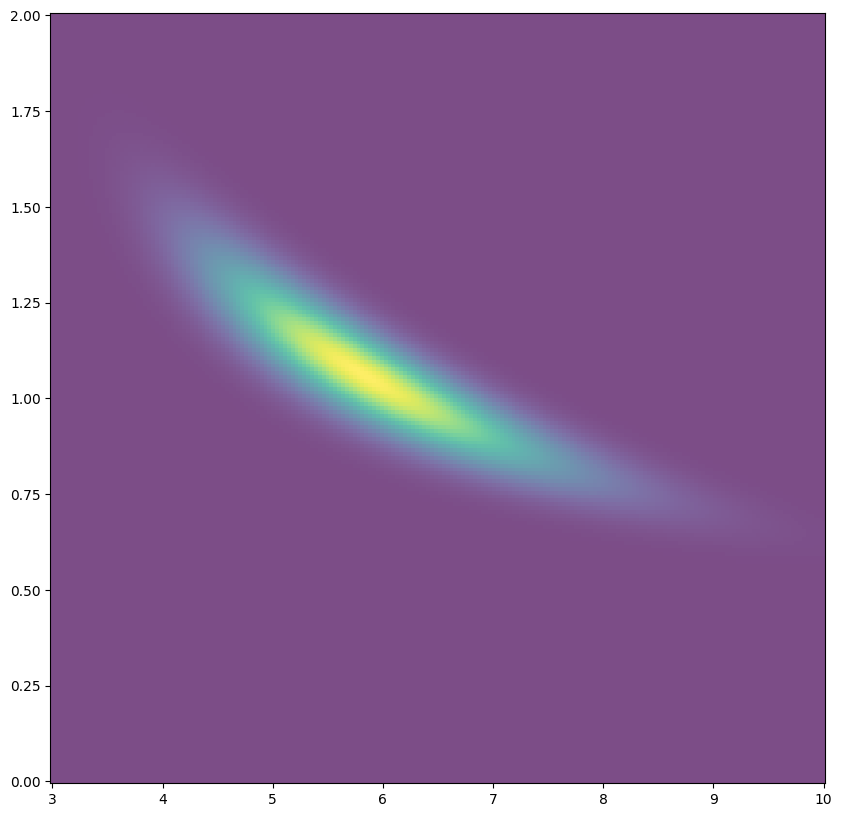

In [46]:
plot_2d_function(lambda sample: torch.exp(blr.log_joint_distribution(sample[:,0], sample[:,1], x0, D_theta, D_x)), range = [[3,10],[0,2]], bins = (200,200))
plt.show()

In [47]:
prior_phi = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
from tqdm import tqdm
def sample_joint_IMH(number_steps, number_chains):
    current_phi = prior_phi.sample([number_chains])
    current_theta = prior.sample([number_chains])
    pbar = tqdm(range(number_steps))
    for _ in pbar:
        proposed_phi = prior_phi.sample([number_chains])
        proposed_theta = prior.sample([number_chains])
        acceptance_log_prob = blr.log_joint_distribution(proposed_theta,proposed_phi, x0, D_theta, D_x)+prior.log_prob(current_theta) + prior_phi.log_prob(current_phi) - blr.log_joint_distribution(current_theta,current_phi, x0, D_theta, D_x) -prior.log_prob(proposed_theta) - prior_phi.log_prob(proposed_phi)
        mask = (torch.rand(number_chains) < torch.exp(acceptance_log_prob))
        current_phi = (mask)*proposed_phi + (~mask)*current_phi
        current_theta = (mask)*proposed_theta + (~mask)*current_theta
        pbar.set_postfix_str(str((1.*mask).mean()))
    return current_phi, current_theta
phi_samples_joint, theta_samples_joint = sample_joint_IMH(50,5000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.26it/s, tensor(0.0532)]


In [48]:
list_theta_invalid = []
list_phi_invalid = []
for t in tqdm(range(10000)):
    mu_phi_given_D, sigma2_phi_given_D = blr.compute_phi_given_D_moments(D_theta, D_x)
    current_phi = torch.distributions.Normal(mu_phi_given_D, torch.sqrt(sigma2_phi_given_D)).sample()
    mu_theta_given_x0_phi, sigma2_theta_given_x0_phi = blr.compute_theta_given_x0_phi_moments(x0,current_phi)
    current_theta = torch.distributions.Normal(mu_theta_given_x0_phi, torch.sqrt(sigma2_theta_given_x0_phi)).sample()
    list_theta_invalid.append(current_theta)
    list_phi_invalid.append(current_phi)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2624.47it/s]


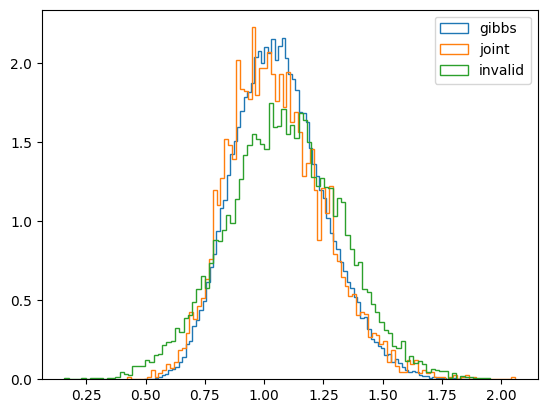

In [49]:
phi_gibbs = torch.stack(list_phi_gibbs)
phi_invalid = torch.stack(list_phi_invalid)
plt.hist(phi_gibbs.numpy(),density= True, bins = 100, label = 'gibbs', histtype = 'step')
plt.hist(phi_samples_joint.numpy(),density= True, bins = 100, label = 'joint',histtype = 'step')
plt.hist(phi_invalid.numpy(),density= True, bins = 100, label = 'invalid',histtype = 'step')
plt.legend()
plt.show()

In [50]:
from tqdm import tqdm
def sample_marginal_IMH(number_steps, number_chains):
    current_theta = prior.sample([number_chains])
    pbar = tqdm(range(number_steps))
    for _ in pbar:
        proposed_theta = prior.sample([number_chains])
        acceptance_log_prob = blr.marginal_log_posterior(proposed_theta,x0, D_theta, D_x) - blr.marginal_log_posterior(current_theta,x0, D_theta, D_x)
        mask = torch.rand(number_chains) < torch.exp(acceptance_log_prob)
        current_theta = (mask)*proposed_theta + (~mask)*current_theta
        pbar.set_postfix_str(str((1.*mask).mean()))
    return current_theta
theta_samples_marginal = sample_marginal_IMH(50,5000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s, tensor(0.6722)]


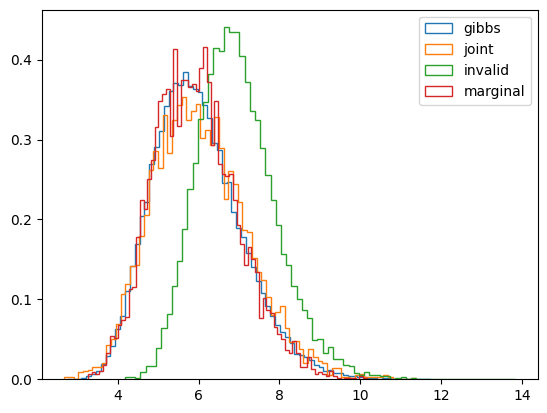

In [51]:
theta_gibbs=torch.stack(list_theta_gibbs)
plt.hist(theta_gibbs.numpy(),density= True, bins = 75, label = 'gibbs', histtype = 'step')
plt.hist(theta_samples_joint.numpy(),density= True, bins = 75, label = 'joint',histtype = 'step')
plt.hist(theta_invalid.numpy(),density= True, bins = 75, label = 'invalid',histtype = 'step')
plt.hist(theta_samples_marginal.numpy(),density= True, bins = 75, label = 'marginal',histtype = 'step')
plt.legend()
plt.show()

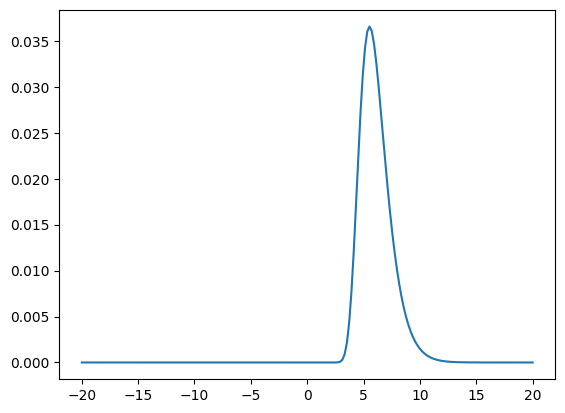

In [52]:
tt = torch.linspace(-20,20, 200)
plt.plot(tt, torch.exp(blr.marginal_log_posterior(tt,x0, D_theta, D_x)))